In [1]:
import numpy as np

import rasterio
from rasterio import Affine
from rasterio.windows import Window
from rasterio.transform import from_bounds

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from skimage.transform import rescale, resize

In [16]:
# grid_119
COG_URL = 'https://oin-hotosm.s3.amazonaws.com/5ae38a540b093000130afe97/0/5ae38a540b093000130afe98.tif'

In [2]:
# grid_029
COG_URL = 'https://oin-hotosm.s3.amazonaws.com/5ae242fd0b093000130afd38/0/5ae242fd0b093000130afd39.tif'

In [2]:
# grid_042
COG_URL = 'https://oin-hotosm.s3.amazonaws.com/5ae318220b093000130afd64/0/5ae318220b093000130afd65.tif'

In [3]:
def get_windows(rst_h, rst_w, max_h, max_w, col_off = 0, row_off = 0):
    wins = []
    rows = rst_h // max_h + 1
    cols = rst_w // max_w + 1    
    
    for r in range(rows):
        if r == rows-1: height = rst_h % max_h
        else: height = max_h
            
        for c in range(cols):
            if c == cols-1: width = rst_w % max_w
            else: width = max_w

            if width != 0 and height != 0: 
                wins.append(((r,c),Window(c*max_w+col_off, r*max_h+row_off, width, height)))
    return wins

In [4]:
def get_tfm(window, rst_full):
    c_o, r_o, w, h = window.flatten()
    left, top, right, bottom = *rst_full.xy(r_o, c_o, offset='ul'), *rst_full.xy(r_o+h, c_o+w, offset='lr')
    tfm = from_bounds(left,bottom,right,top, w, h)
    return tfm

In [5]:
def save_subwin(arr, crs, tfm, save_fn):
    im = (arr*255).astype('uint8')
    with rasterio.open(OUTPUT/f'{save_fn}.tif', 'w', driver='GTiff', 
                            height=im.shape[0], width=im.shape[1],
                            count=3, dtype=im.dtype, crs=crs, transform=tfm, compress='JPEG', tiled=True) as dst:
        for k, a in [(1, im), (2, im), (3, im)]:
            dst.write(a, indexes=k)

In [6]:
def pad_window(window, pad):
    col_off, row_off, width, height = window.flatten()
    return Window(col_off-pad//2, row_off-pad//2,width+pad,height+pad)

In [12]:
OUTPUT = Path('outputs')

In [13]:
raster = rasterio.open(COG_URL,'r')
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 40551,
 'height': 40592,
 'count': 3,
 'crs': CRS({'init': 'epsg:32737'}),
 'transform': Affine(0.07398000359535217, 0.0, 534722.5625,
        0.0, -0.07398000359535217, 9347193.0)}

In [14]:
from fastai.vision import *

path = Path('data/znz-segment/znz-train-all')
path_img = path/'images-512'
path_lbl = path/'masks-512'
get_y_fn = lambda x: path_lbl/f'{x.stem.split("_img")[0]}_mask_buffered.png'
codes = np.array(['Empty','Building'])
unet_sz = 768
bs=1

data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=unet_sz)
        .databunch(bs=bs)
        .normalize(imagenet_stats))        

learn = unet_learner(data, models.resnet34)
learn.load('20190108-rn34unet-comboloss-alldata-512-unfreeze-best')
learn.model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [15]:
def get_pred(learn, tile):
    t_img = Image(pil2tensor(tile,np.float32))
    outputs = learn.predict(t_img)
    im = (outputs[2][1]).numpy()
    return im

# Run inference on subwindows of windows and save raster

In [16]:
tif_sz = 20480 
tile_sz = 512
pad_sz = tile_sz//2
pred_sz = tile_sz+pad_sz

print(tile_sz, pad_sz, pred_sz)
assert pred_sz == unet_sz

scale_factor = 1
save_prefix = f'grid_042_20190118_test{scale_factor}x'

512 256 768


In [ ]:
tile_scaled = tile_sz*scale_factor
pad_scaled = pad_sz*scale_factor
test_wins = get_windows(raster.meta['height'], raster.meta['width'], tif_sz, tif_sz)

print(len(test_wins))
for idx, win in enumerate(test_wins):
    print(idx, win)
    
    # make subwindows and blank array to fill in
    col_off, row_off, rst_w, rst_h = win[1].flatten()
    sub_wins = get_windows(rst_h, rst_w, tile_scaled, tile_scaled, col_off, row_off)
    new_arr = np.zeros((rst_h, rst_w))

    for (row_idx, col_idx), window in tqdm(sub_wins):
        win_padded = pad_window(window, pad_scaled)
        win_img = np.rollaxis(raster.read(window=win_padded, boundless=True),0,3)/255

        # scale down windowed read to unet input size
        win_img = rescale(win_img,1/scale_factor,anti_aliasing=False)
        placeholder = np.zeros((pred_sz,pred_sz,3))
        placeholder[:win_img.shape[0],:win_img.shape[1]] = win_img
        
        # skip inference if empty window
        if placeholder.max() > 0: pr = get_pred(learn, placeholder)
        else: pr = placeholder[:,:,0]
        
        # scale back up to original tile size to fill into blank array at right place
        pr = rescale(pr, scale_factor, anti_aliasing=False)
        pr = pr[pad_scaled//2:-pad_scaled//2,pad_scaled//2:-pad_scaled//2]

        try: 
            width, height = window.flatten()[-2:]
            start_y = row_idx*tile_scaled
            start_x = col_idx*tile_scaled
            new_arr[start_y:start_y+height, start_x:start_x+width]= pr[:height,:width]
        except Exception as exc: print(f'{exc}')
    
    tfm = get_tfm(win[1], raster)
    save_subwin(new_arr, raster.meta['crs'].data['init'], tfm, f'{save_prefix}_id{idx}')

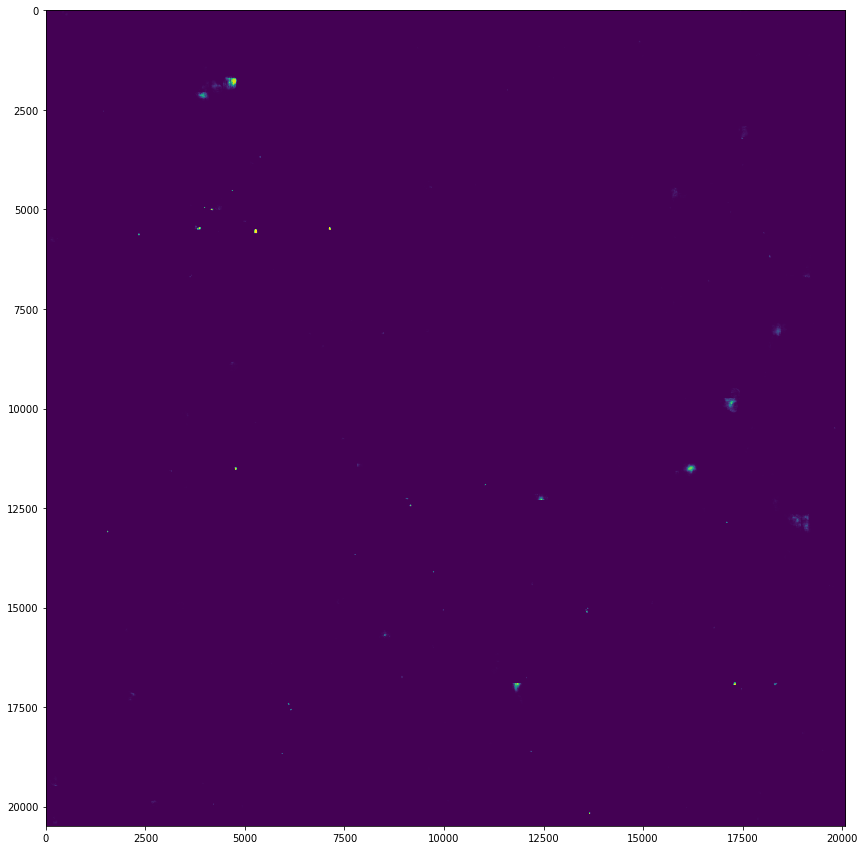

In [52]:
plt.figure(figsize=(15,15))
plt.imshow(new_arr)

## Merge rasters

In [18]:
from rasterio.merge import merge

In [19]:
fns = sorted([o.name for o in OUTPUT.iterdir() if save_prefix in o.name])

In [20]:
fns

['grid_042_20190118_test1x_id0.tif',
 'grid_042_20190118_test1x_id1.tif',
 'grid_042_20190118_test1x_id2.tif',
 'grid_042_20190118_test1x_id3.tif']

In [21]:
src_files_to_mosaic = []

for fn in fns:
    src = rasterio.open(OUTPUT/fn)
    src_files_to_mosaic.append(src)

In [22]:
mosaic, out_tfm = merge(src_files_to_mosaic)

In [23]:
out_tfm, mosaic.shape

(Affine(0.07398361590021522, 0.0, 534722.5625,
        0.0, -0.07398361590021522, 9347193.0), (3, 40592, 40551))

In [24]:
out_meta = src.meta.copy()
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 20071,
 'height': 20112,
 'count': 3,
 'crs': CRS({'init': 'epsg:32737'}),
 'transform': Affine(0.07398368951053305, 0.0, 536237.6729736328,
        0.0, -0.0739836819964856, 9345677.889526367)}

In [25]:
out_meta.update({"driver": "GTiff",
                 "count:":1,
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_tfm,
                 "compress": "jpeg",
                 "tiled": True
                })

In [26]:
with rasterio.open(OUTPUT/f'{save_prefix}_merged.tif', "w", **out_meta) as dest:
    dest.write(mosaic)